## TRAIN/TEST/VAL SPLIT (80/10/10)

In [1]:
import os
import shutil
import random
from tqdm import tqdm

# Set seed for reproducibility
random.seed(42)

# Paths
root_dir = r"D:\internship\gnctd\biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054\biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054\Dataset"  # Your full dataset path here
output_base = os.path.join(root_dir, "segmentation_dataset")

# Create folders
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_base, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_base, split, "masks"), exist_ok=True)

# Get all subfolders
all_folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
random.shuffle(all_folders)

# Split
num_total = len(all_folders)
num_train = int(0.8 * num_total)
num_val = int(0.1 * num_total)

splits = {
    'train': all_folders[:num_train],
    'val': all_folders[num_train:num_train+num_val],
    'test': all_folders[num_train+num_val:]
}

# Copy files
for split, folders in splits.items():
    for folder in tqdm(folders, desc=f"Copying {split} data"):
        folder_path = os.path.join(root_dir, folder)
        image_file = os.path.join(folder_path, f"{folder}_RAW.jpg")
        mask_file = os.path.join(folder_path, f"{folder}_COMBINED.png")

        if not os.path.exists(image_file) or not os.path.exists(mask_file):
            print(f"Skipping {folder} due to missing files.")
            continue

        shutil.copy(image_file, os.path.join(output_base, split, "images", f"{folder}.jpg"))
        shutil.copy(mask_file, os.path.join(output_base, split, "masks", f"{folder}.png"))

print("✅ Dataset prepared and split into train/val/test.")


Copying test data:  52%|██████████████████████████████████████▍                                   | 117/225 [00:06<00:05, 19.42it/s]

Skipping segmentation_dataset due to missing files.


Copying test data: 100%|██████████████████████████████████████████████████████████████████████████| 225/225 [00:13<00:00, 16.78it/s]

✅ Dataset prepared and split into train/val/test.


## CUSTOM DATASET CLASS

In [4]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = np.array(image)
        mask = np.array(mask)

        # Convert pixel values (0, 127, 255) to class indices (0, 1, 2)
        mask = np.where(mask == 255, 2, np.where(mask == 127, 1, 0)).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Convert to tensors
        image = T.ToTensor()(image)
        mask = torch.from_numpy(mask).long()

        return image, mask

## DATA LOADERS AND TRANSFORMERS

In [1]:
from torch.utils.data import DataLoader

def get_loaders(root_dir, batch_size=8):
    train_dataset = SegmentationDataset(
        image_dir=os.path.join(root_dir, "train/images"),
        mask_dir=os.path.join(root_dir, "train/masks")
    )
    val_dataset = SegmentationDataset(
        image_dir=os.path.join(root_dir, "val/images"),
        mask_dir=os.path.join(root_dir, "val/masks")
    )
    test_dataset = SegmentationDataset(
        image_dir=os.path.join(root_dir, "test/images"),
        mask_dir=os.path.join(root_dir, "test/masks")
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader

In [2]:
root_dir = r"D:\internship\gnctd\biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054\biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054\Dataset\segmentation_dataset"
import os

# Confirm paths
print("Checking paths...")
for split in ["train", "val", "test"]:
    img_dir = os.path.join(root_dir, split, "images")
    mask_dir = os.path.join(root_dir, split, "masks")

    print(f"{split.capitalize()} Images Path Exists:", os.path.isdir(img_dir))
    print(f"{split.capitalize()} Masks Path Exists:", os.path.isdir(mask_dir))

Checking paths...
Train Images Path Exists: True
Train Masks Path Exists: True
Val Images Path Exists: True
Val Masks Path Exists: True
Test Images Path Exists: True
Test Masks Path Exists: True


In [5]:
# Load data using your loader
train_loader, val_loader, test_loader = get_loaders(root_dir)

In [6]:
import os

root_dir = r"D:\internship\gnctd\biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054\biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054\Dataset\segmentation_dataset"

train_dataset = SegmentationDataset(
    image_dir=os.path.join(root_dir, "train/images"),
    mask_dir=os.path.join(root_dir, "train/masks")
)

# Now test loading a few samples
for i in range(5):
    img, mask = train_dataset[i]
    print(f"Sample {i}: img shape {img.shape}, mask shape {mask.shape}")

Sample 0: img shape torch.Size([3, 640, 1024]), mask shape torch.Size([640, 1024])
Sample 1: img shape torch.Size([3, 640, 1024]), mask shape torch.Size([640, 1024])
Sample 2: img shape torch.Size([3, 640, 1024]), mask shape torch.Size([640, 1024])
Sample 3: img shape torch.Size([3, 640, 1024]), mask shape torch.Size([640, 1024])
Sample 4: img shape torch.Size([3, 640, 1024]), mask shape torch.Size([640, 1024])


In [7]:
from tqdm import tqdm

# Sample check with progress bar and debugging
for batch_idx, (imgs, masks) in enumerate(tqdm(train_loader, desc="Loading train batches")):
    print(f"Batch {batch_idx + 1}:")
    print("  Image batch shape:", imgs.shape)   # Expected: [B, 3, H, W]
    print("  Mask batch shape:", masks.shape)   # Expected: [B, H, W]
    break  # Remove break to process all batches


Loading train batches:   0%|                                                                                | 0/224 [00:01<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [3, 640, 1024] at entry 0 and [3, 630, 1024] at entry 2

## DEALING WITH UNEQUAL SIZE IMAGES

Loading test/images: 100%|███████████████████████████████████████████████████████████████████| 224/224 [00:01<00:00, 112.93images/s]


Height statistics:
Max: 640, Min: 630, Mean: 635.49, Median: 640.0
75th percentile: 640.0

Width statistics:
Max: 1024, Min: 1024, Mean: 1024.00, Median: 1024.0
75th percentile: 1024.0


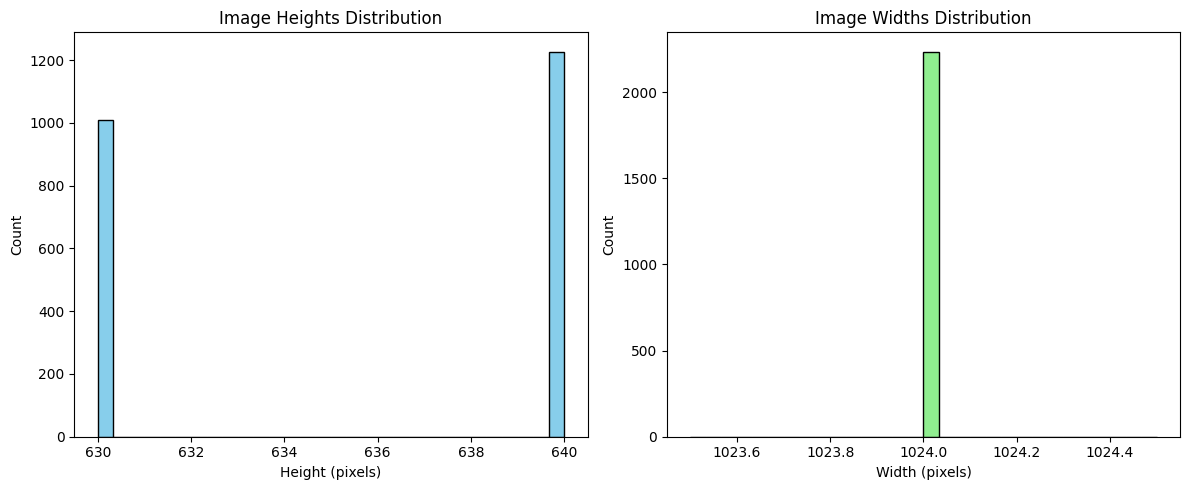

In [9]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Root dir of your dataset images (train, val, test)
root_dir = r"D:\internship\gnctd\biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054\biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054\Dataset\segmentation_dataset"

# Subfolders to scan for images
subfolders = ["train/images", "val/images", "test/images"]

heights = []
widths = []

for subfolder in subfolders:
    folder_path = os.path.join(root_dir, subfolder)
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for fname in tqdm(files, desc=f"Loading {subfolder}", unit="images"):
        img_path = os.path.join(folder_path, fname)
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)

# Convert to numpy arrays
heights = np.array(heights)
widths = np.array(widths)

# Print metrics
print("Height statistics:")
print(f"Max: {heights.max()}, Min: {heights.min()}, Mean: {heights.mean():.2f}, Median: {np.median(heights)}")
print(f"75th percentile: {np.percentile(heights, 75)}")
print()
print("Width statistics:")
print(f"Max: {widths.max()}, Min: {widths.min()}, Mean: {widths.mean():.2f}, Median: {np.median(widths)}")
print(f"75th percentile: {np.percentile(widths, 75)}")

# Plot distributions
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist(heights, bins=30, color='skyblue', edgecolor='black')
plt.title("Image Heights Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(widths, bins=30, color='lightgreen', edgecolor='black')
plt.title("Image Widths Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [3]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

class PaddedSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir

        # List all images (jpg, jpeg, png)
        self.filenames = sorted([
            fname for fname in os.listdir(images_dir)
            if fname.lower().endswith((".png", ".jpg", ".jpeg"))
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Get image filename
        fname = self.filenames[idx]
        img_path = os.path.join(self.images_dir, fname)

        # Construct corresponding mask filename by replacing extension with .png
        mask_name = os.path.splitext(fname)[0] + ".png"
        mask_path = os.path.join(self.masks_dir, mask_name)

        # Load image and mask
        image = Image.open(img_path).convert("RGB")   # (W, H)
        mask = Image.open(mask_path)                  # single-channel

        # Target size
        target_h, target_w = 640, 1024

        w, h = image.size  # PIL gives size as (width, height)

        # Padding calculation for height only, width is assumed 1024 fixed
        if h < target_h:
            pad_total = target_h - h
            pad_top = pad_total // 2
            pad_bottom = pad_total - pad_top
            padding = (0, pad_top, 0, pad_bottom)  # (left, top, right, bottom)
            image = TF.pad(image, padding, fill=0)
            mask = TF.pad(mask, padding, fill=0)

        # Convert to tensor
        image_tensor = TF.to_tensor(image)  # [3, H, W], float32 [0,1]

        # Convert mask to numpy for label mapping
        mask_np = np.array(mask, dtype=np.uint8)

        # Map mask pixel values: 0 -> 0, 127 -> 1, 255 -> 2
        mask_np = np.where(mask_np == 255, 2, np.where(mask_np == 127, 1, 0))
        mask_tensor = torch.from_numpy(mask_np).long()  # [H, W], int64

        return image_tensor, mask_tensor

In [7]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm

root_dir = r"D:\internship\gnctd\biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054\biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054\Dataset\segmentation_dataset"

train_dataset = PaddedSegmentationDataset(
    images_dir=os.path.join(root_dir, "train", "images"),
    masks_dir=os.path.join(root_dir, "train", "masks")
)
val_dataset = PaddedSegmentationDataset(
    images_dir=os.path.join(root_dir, "val", "images"),
    masks_dir=os.path.join(root_dir, "val", "masks")
)
test_dataset = PaddedSegmentationDataset(
    images_dir=os.path.join(root_dir, "test", "images"),
    masks_dir=os.path.join(root_dir, "test", "masks")
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False, num_workers=0)

# Quick check with progress bar
for imgs, masks in tqdm(train_loader, desc="Loading train batches"):
    print("Image batch:", imgs.shape)  # [8, 3, 640, 1024]
    print("Mask batch:", masks.shape)  # [8, 640, 1024]
    break;

Loading train batches:   0%|                                                                                | 0/224 [00:00<?, ?it/s]

Image batch: torch.Size([8, 3, 640, 1024])
Mask batch: torch.Size([8, 640, 1024])
